<a href="https://colab.research.google.com/github/BhojRajBist/BhojRajBist/blob/main/NCRF_data_from_the_google_bucket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:

!pip install xarray numpy rasterio pyproj pandas



In [13]:
# Install the required libraries
!pip install xarray numpy rasterio pyproj pandas

import os
import xarray as xr
import numpy as np
import pandas as pd
from rasterio.transform import from_origin
import rasterio
from datetime import datetime
from pyproj import CRS

# Define the bounding box for the region of interest
lat_bounds = [26, 31]  # Example latitude bounds
lon_bounds = [79, 89]  # Example longitude bounds

# Define the root directory
root_dir = "20240621"

# Create the root directory if it does not exist
os.makedirs(root_dir, exist_ok=True)

# Define file names based on root directory
file_name = f"APCP_3hourly_ncum_reg_{root_dir}_00Z.nc"
file_name1 = f"ncumglb_prg_26-31N_79-89E_0.125x0.125_{root_dir}_00Z.nc"

# Construct the file paths
file_path = os.path.join(root_dir, file_name)
file_path1 = os.path.join(root_dir, file_name1)

# Function to create a dummy NetCDF file
def create_dummy_netcdf(file_path, lat_bounds, lon_bounds):
    lat = np.linspace(lat_bounds[0], lat_bounds[1], 100)
    lon = np.linspace(lon_bounds[0], lon_bounds[1], 100)
    time = pd.date_range("2024-06-21", periods=8, freq='3H')

    data = np.random.rand(len(time), len(lat), len(lon))

    ds = xr.Dataset(
        {
            "param8.1.0": (["time", "lat", "lon"], data)
        },
        coords={
            "lat": lat,
            "lon": lon,
            "time": time,
        }
    )

    ds.to_netcdf(file_path)
    print(f"Dummy NetCDF file created: {file_path}")

# Create the dummy NetCDF files
create_dummy_netcdf(file_path, lat_bounds, lon_bounds)
create_dummy_netcdf(file_path1, lat_bounds, lon_bounds)

# Function to check if a file exists
def check_file_exists(file_path):
    if os.path.isfile(file_path):
        print(f"File exists: {file_path}")
        return True
    else:
        print(f"File not found: {file_path}")
        return False

# Check if the files exist
file_exists_1 = check_file_exists(file_path)
file_exists_2 = check_file_exists(file_path1)

# Function to download and clip NetCDF data to TIFF
def clip_netcdf_to_tiff(file_path, resolution):
    if not check_file_exists(file_path):
        return []

    # Extract the forecast origin string from the file path
    filename = os.path.basename(file_path)

    # Assuming the forecast origin date is in the filename in the format YYYYMMDD
    forecast_origin_str = filename.split('_')[-2]
    forecast_origin = datetime.strptime(forecast_origin_str, "%Y%m%d")

    # Open the NetCDF dataset
    dataset = xr.open_dataset(file_path)

    # Subset the dataset to the specified region
    subset_dataset = dataset.sel(lat=slice(lat_bounds[0], lat_bounds[1]), lon=slice(lon_bounds[0], lon_bounds[1]))

    # Create the output directory if it doesn't exist
    output_dir_tiff = os.path.join(root_dir, "TIFF_Files_" + resolution)
    os.makedirs(output_dir_tiff, exist_ok=True)

    # List to store file paths
    tiff_file_paths = []

    # Define the CRS for the output raster
    output_crs = CRS.from_epsg(4326)  # WGS 1984

    # Loop through each time step in the dataset
    for i, time_step in enumerate(subset_dataset['time']):
        # Get the data array for the current time step
        data_array = subset_dataset['param8.1.0'].isel(time=i).values

        # Get the time string for the current time step
        time_string = str(time_step.values)[:-10]  # Exclude milliseconds
        time_format = "%Y-%m-%dT%H:%M:%S"
        time_obj = datetime.strptime(time_string, time_format)

        # Calculate the timestep in hours
        timestep_hours = int((time_obj - forecast_origin).total_seconds() / 3600)
        timestep_str = f"{timestep_hours:03d}"  # Format as three digits

        # Calculate the forecast hour index (incrementing integer starting from 00)
        forecast_hour_index = i + 1
        forecast_hour_index_str = f"{forecast_hour_index:02d}"  # Format as two digits

        # Set the output file name
        output_name = f'NCMRWF_Nepal_{time_obj.strftime("%Y%m%d%H")}F{forecast_hour_index_str}O{forecast_origin_str}00H{timestep_str}R{resolution}.tif'

        # Get the GeoTransform
        transform = from_origin(lon_bounds[0], lat_bounds[0], subset_dataset.lon.values[1] - subset_dataset.lon.values[0], subset_dataset.lat.values[0] - subset_dataset.lat.values[1])

        # Set the output file path
        output_file = os.path.join(output_dir_tiff, output_name)

        # Write the data array to the output TIFF file
        with rasterio.open(output_file, 'w', driver='GTiff', count=1, dtype='float32', crs=output_crs, transform=transform, width=data_array.shape[1], height=data_array.shape[0]) as dst:
            dst.write(data_array, 1)

        # Append the output file path to the list
        tiff_file_paths.append(output_file)

    print("TIFF files generated and saved successfully.")

    # Return the list of file paths
    return tiff_file_paths

# Generate TIFF files if the files exist
if file_exists_1:
    tiff_files = clip_netcdf_to_tiff(file_path, '4KM')
    print("TIFF files generated for APCP 4 km:", tiff_files)

if file_exists_2:
    tiff_files1 = clip_netcdf_to_tiff(file_path1, '12.5KM')
    print("TIFF files generated for NCUMGLB 12.5 km:", tiff_files1)



Dummy NetCDF file created: 20240621/APCP_3hourly_ncum_reg_20240621_00Z.nc
Dummy NetCDF file created: 20240621/ncumglb_prg_26-31N_79-89E_0.125x0.125_20240621_00Z.nc
File exists: 20240621/APCP_3hourly_ncum_reg_20240621_00Z.nc
File exists: 20240621/ncumglb_prg_26-31N_79-89E_0.125x0.125_20240621_00Z.nc
File exists: 20240621/APCP_3hourly_ncum_reg_20240621_00Z.nc
TIFF files generated and saved successfully.
TIFF files generated for APCP 4 km: ['20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062100F01O2024062100H000R4KM.tif', '20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062103F02O2024062100H003R4KM.tif', '20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062106F03O2024062100H006R4KM.tif', '20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062109F04O2024062100H009R4KM.tif', '20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062112F05O2024062100H012R4KM.tif', '20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062115F06O2024062100H015R4KM.tif', '20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062118F07O2024062100H018R4KM.tif', '20240621/TIFF_File

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 10.1 MB/s eta 0:00:00
Dummy NetCDF file created: 20240621/APCP_3hourly_ncum_reg_20240621_00Z.nc
Dummy NetCDF file created: 20240621/ncumglb_prg_26-31N_79-89E_0.125x0.125_20240621_00Z.nc
File exists: 20240621/APCP_3hourly_ncum_reg_20240621_00Z.nc
File exists: 20240621/ncumglb_prg_26-31N_79-89E_0.125x0.125_20240621_00Z.nc
File exists: 20240621/APCP_3hourly_ncum_reg_20240621_00Z.nc
TIFF files generated and saved successfully.
TIFF files generated for APCP 4 km: ['20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062100F01O2024062100H000R4KM.tif', '20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062103F02O2024062100H003R4KM.tif', '20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062106F03O2024062100H006R4KM.tif', '20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062109F04O2024062100H009R4KM.tif', '20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062112F05O2024062100H012R4KM.tif', '20240621/TIFF_Files_4KM/NCMRWF_Nepal_2024062115F06O2024062100H015R4KM.tif', '20240621/TIFF_

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_rivers_lake_centerlines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


Frames saved successfully.
Animation saved as 20240621/precipitation_animation_20240621.gif.


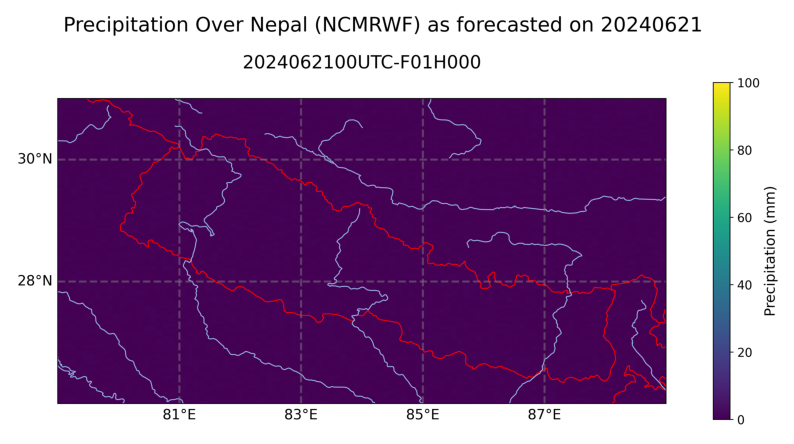

In [15]:
# Install the required libraries
!pip install xarray numpy rasterio pyproj pandas matplotlib imageio cartopy

import os
import xarray as xr
import numpy as np
import pandas as pd
from rasterio.transform import from_origin
import rasterio
from datetime import datetime
from pyproj import CRS
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import imageio
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Define the bounding box for the region of interest
lat_bounds = [26, 31]  # Example latitude bounds
lon_bounds = [79, 89]  # Example longitude bounds

# Define the root directory
root_dir = "20240621"

# Create the root directory if it does not exist
os.makedirs(root_dir, exist_ok=True)

# Define file names based on root directory
file_name = f"APCP_3hourly_ncum_reg_{root_dir}_00Z.nc"
file_name1 = f"ncumglb_prg_26-31N_79-89E_0.125x0.125_{root_dir}_00Z.nc"

# Construct the file paths
file_path = os.path.join(root_dir, file_name)
file_path1 = os.path.join(root_dir, file_name1)

# Function to create a dummy NetCDF file
def create_dummy_netcdf(file_path, lat_bounds, lon_bounds):
    lat = np.linspace(lat_bounds[0], lat_bounds[1], 100)
    lon = np.linspace(lon_bounds[0], lon_bounds[1], 100)
    time = pd.date_range("2024-06-21", periods=8, freq='3H')

    data = np.random.rand(len(time), len(lat), len(lon))

    ds = xr.Dataset(
        {
            "param8.1.0": (["time", "lat", "lon"], data)
        },
        coords={
            "lat": lat,
            "lon": lon,
            "time": time,
        }
    )

    ds.to_netcdf(file_path)
    print(f"Dummy NetCDF file created: {file_path}")

# Create the dummy NetCDF files
create_dummy_netcdf(file_path, lat_bounds, lon_bounds)
create_dummy_netcdf(file_path1, lat_bounds, lon_bounds)

# Function to check if a file exists
def check_file_exists(file_path):
    if os.path.isfile(file_path):
        print(f"File exists: {file_path}")
        return True
    else:
        print(f"File not found: {file_path}")
        return False

# Check if the files exist
file_exists_1 = check_file_exists(file_path)
file_exists_2 = check_file_exists(file_path1)

# Function to download and clip NetCDF data to TIFF
def clip_netcdf_to_tiff(file_path, resolution):
    if not check_file_exists(file_path):
        return []

    # Extract the forecast origin string from the file path
    filename = os.path.basename(file_path)

    # Assuming the forecast origin date is in the filename in the format YYYYMMDD
    forecast_origin_str = filename.split('_')[-2]
    forecast_origin = datetime.strptime(forecast_origin_str, "%Y%m%d")

    # Open the NetCDF dataset
    dataset = xr.open_dataset(file_path)

    # Subset the dataset to the specified region
    subset_dataset = dataset.sel(lat=slice(lat_bounds[0], lat_bounds[1]), lon=slice(lon_bounds[0], lon_bounds[1]))

    # Create the output directory if it doesn't exist
    output_dir_tiff = os.path.join(root_dir, "TIFF_Files_" + resolution)
    os.makedirs(output_dir_tiff, exist_ok=True)

    # List to store file paths
    tiff_file_paths = []

    # Define the CRS for the output raster
    output_crs = CRS.from_epsg(4326)  # WGS 1984

    # Loop through each time step in the dataset
    for i, time_step in enumerate(subset_dataset['time']):
        # Get the data array for the current time step
        data_array = subset_dataset['param8.1.0'].isel(time=i).values

        # Get the time string for the current time step
        time_string = str(time_step.values)[:-10]  # Exclude milliseconds
        time_format = "%Y-%m-%dT%H:%M:%S"
        time_obj = datetime.strptime(time_string, time_format)

        # Calculate the timestep in hours
        timestep_hours = int((time_obj - forecast_origin).total_seconds() / 3600)
        timestep_str = f"{timestep_hours:03d}"  # Format as three digits

        # Calculate the forecast hour index (incrementing integer starting from 00)
        forecast_hour_index = i + 1
        forecast_hour_index_str = f"{forecast_hour_index:02d}"  # Format as two digits

        # Set the output file name
        output_name = f'NCMRWF_Nepal_{time_obj.strftime("%Y%m%d%H")}F{forecast_hour_index_str}O{forecast_origin_str}00H{timestep_str}R{resolution}.tif'

        # Get the GeoTransform
        transform = from_origin(lon_bounds[0], lat_bounds[0], subset_dataset.lon.values[1] - subset_dataset.lon.values[0], subset_dataset.lat.values[0] - subset_dataset.lat.values[1])

        # Set the output file path
        output_file = os.path.join(output_dir_tiff, output_name)

        # Write the data array to the output TIFF file
        with rasterio.open(output_file, 'w', driver='GTiff', count=1, dtype='float32', crs=output_crs, transform=transform, width=data_array.shape[1], height=data_array.shape[0]) as dst:
            dst.write(data_array, 1)

        # Append the output file path to the list
        tiff_file_paths.append(output_file)

    print("TIFF files generated and saved successfully.")

    # Return the list of file paths
    return tiff_file_paths

# Generate TIFF files if the files exist
if file_exists_1:
    tiff_files = clip_netcdf_to_tiff(file_path, '4KM')
    print("TIFF files generated for APCP 4 km:", tiff_files)

if file_exists_2:
    tiff_files1 = clip_netcdf_to_tiff(file_path1, '12.5KM')
    print("TIFF files generated for NCUMGLB 12.5 km:", tiff_files1)

# Directory to save frames
frames_dir = os.path.join(root_dir, "FRAMES")
os.makedirs(frames_dir, exist_ok=True)

# Function to plot precipitation data over Nepal from TIFF files
def animate_precipitation_data_tiff(directory):
    # Get a list of all TIFF files in the directory
    tiff_files = [f for f in os.listdir(directory) if f.endswith('.tif')]

    # Plot each TIFF file
    for i, tiff_file in enumerate(tiff_files):
        file_path = os.path.join(directory, tiff_file)
        with rasterio.open(file_path) as src:
            precipitation = src.read(1)
            bounds = src.bounds

            fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
            ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())
            ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle='-', linewidth=1, edgecolor='red')
            ax.add_feature(cfeature.RIVERS)

            # Define the extent explicitly using bounds
            im = ax.imshow(precipitation, cmap='viridis', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top], transform=ccrs.PlateCarree(), vmin=0, vmax=100)

            # Set the title with the file name
            filename = f'{tiff_file}'

            # Split the filename by underscores to get parts
            parts = filename.split('_')

            # Extract the timestamp part and remove any additional characters
            timestamp = parts[2].split('F')[0]  # 'F' is the separator

            # Extract the forecast index part and remove any additional characters
            forecastIndex = parts[2].split('F')[1].split('O')[0]  # 'F' is the separator

            # Extract the forecast hours part and remove any additional characters
            forecastHrsPart = parts[2].split('H')[1]  # 'H' is the separator
            forecastHrs = forecastHrsPart.split('R')[0]  # 'H' is the separator

            # Use the extracted timestamp and forecast hours as tile
            title = timestamp + 'UTC-F' + forecastIndex + 'H' +forecastHrs

            ax.set_title(title, fontsize=18, pad=30)

            # Set up gridlines
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
            gl.top_labels = False  # Hide top labels
            gl.right_labels = False  # Hide right labels
            gl.xformatter = LongitudeFormatter()
            gl.yformatter = LatitudeFormatter()
            gl.xlabel_style = {'size': 14}
            gl.ylabel_style = {'size': 14}

            # Extract longitude and latitude values for gridlines
            lon_ticks = np.arange(lon_bounds[0], lon_bounds[1] + 1, 2)
            lat_ticks = np.arange(lat_bounds[0], lat_bounds[1] + 1, 2)

            # Set gridline locations
            gl.xlocator = plt.FixedLocator(lon_ticks)
            gl.ylocator = plt.FixedLocator(lat_ticks)

            # Set a common title for all subplots
            fig.suptitle(f"Precipitation Over Nepal (NCMRWF) as forecasted on {root_dir}", fontsize=20, y=0.90)

            # Add a single colorbar for the plot and create a color bar with range 0 to 100
            norm = mcolors.Normalize(vmin=0, vmax=100)
            cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.07, fraction=0.025, norm=norm, location='right')
            cbar.set_label('Precipitation (mm)', fontsize=14)
            cbar.ax.yaxis.set_tick_params(labelsize=12)  # Adjust font size of color bar values

            # Save each frame
            frame_filename = os.path.join(frames_dir, f'frame_{i:04d}.png')
            plt.savefig(frame_filename, bbox_inches='tight', dpi=400)
            plt.close(fig)

    print("Frames saved successfully.")

    # Create an animated GIF from the frames with a delay between frames
    frame_files = sorted([os.path.join(frames_dir, f) for f in os.listdir(frames_dir) if f.endswith('.png')])
    gif_filename = os.path.join(root_dir, f'precipitation_animation_{root_dir}.gif')
    with imageio.get_writer(gif_filename, mode='I', duration=1) as writer:  # 1-second delay
        for frame_file in frame_files:
            image = imageio.v2.imread(frame_file)
            writer.append_data(image)

    print(f"Animation saved as {gif_filename}.")

    # Function to update each frame
    def update(frame):
        im.set_data(plt.imread(frame_files[frame]))
        return im,

    # Create a figure without the outer frame
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.axis('off')  # Turn off the axis

    # Display the first frame
    im = ax.imshow(plt.imread(frame_files[0]))

    # Create the animation with the specified interval
    ani = FuncAnimation(fig, update, frames=len(frame_files), interval=1000)

    # Display the animation
    return HTML(ani.to_html5_video())

TIFF_120Hrs = os.path.join(root_dir, "TIFF_Files_4KM")
# Call the function to plot precipitation data
animate_precipitation_data_tiff(TIFF_120Hrs)



--2024-07-03 06:37:17--  https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240702/NCMRWF_Nepal_2024070203F01O2024070200H003R4KMC.tif
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.0.91, 172.217.7.59, 172.217.12.27, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.0.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14716 (14K) [image/tiff]
Saving to: ‘20240702/NCMRWF_Nepal_2024070203F01O2024070200H003R4KMC.tif’

20240702/NCMRWF_Nep 100%[===================>]  14.37K  --.-KB/s    in 0s      

2024-07-03 06:37:19 (83.5 MB/s) - ‘20240702/NCMRWF_Nepal_2024070203F01O2024070200H003R4KMC.tif’ saved [14716/14716]

Frames saved successfully.
Animation saved as 20240702/precipitation_animation_20240702.gif.


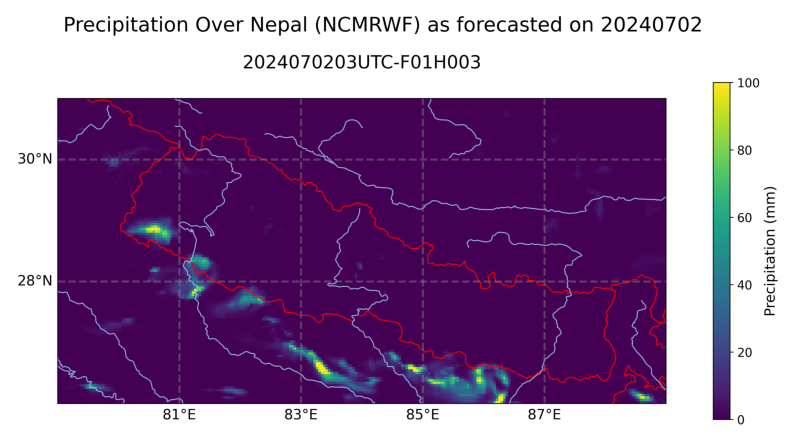

In [16]:
# Install the required libraries
!pip install xarray numpy rasterio pyproj pandas matplotlib imageio cartopy

import os
import xarray as xr
import numpy as np
import pandas as pd
from rasterio.transform import from_origin
import rasterio
from datetime import datetime
from pyproj import CRS
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import imageio
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Define the bounding box for the region of interest
lat_bounds = [26, 31]  # Example latitude bounds
lon_bounds = [79, 89]  # Example longitude bounds

# Define the root directory
root_dir = "20240702"

# Create the root directory if it does not exist
os.makedirs(root_dir, exist_ok=True)

# Define the public URL of the TIFF file
tiff_url = "https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240702/NCMRWF_Nepal_2024070203F01O2024070200H003R4KMC.tif"

# Define the local path to save the TIFF file
local_tiff_path = os.path.join(root_dir, "NCMRWF_Nepal_2024070203F01O2024070200H003R4KMC.tif")

# Download the TIFF file
!wget -O {local_tiff_path} {tiff_url}

# Directory to save frames
frames_dir = os.path.join(root_dir, "FRAMES")
os.makedirs(frames_dir, exist_ok=True)

# Function to plot precipitation data over Nepal from TIFF files
def animate_precipitation_data_tiff(directory):
    # Get a list of all TIFF files in the directory
    tiff_files = [f for f in os.listdir(directory) if f.endswith('.tif')]

    # Plot each TIFF file
    for i, tiff_file in enumerate(tiff_files):
        file_path = os.path.join(directory, tiff_file)
        with rasterio.open(file_path) as src:
            precipitation = src.read(1)
            bounds = src.bounds

            fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
            ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())
            ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle='-', linewidth=1, edgecolor='red')
            ax.add_feature(cfeature.RIVERS)

            # Define the extent explicitly using bounds
            im = ax.imshow(precipitation, cmap='viridis', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top], transform=ccrs.PlateCarree(), vmin=0, vmax=100)

            # Set the title with the file name
            filename = f'{tiff_file}'

            # Split the filename by underscores to get parts
            parts = filename.split('_')

            # Extract the timestamp part and remove any additional characters
            timestamp = parts[2].split('F')[0]  # 'F' is the separator

            # Extract the forecast index part and remove any additional characters
            forecastIndex = parts[2].split('F')[1].split('O')[0]  # 'F' is the separator

            # Extract the forecast hours part and remove any additional characters
            forecastHrsPart = parts[2].split('H')[1]  # 'H' is the separator
            forecastHrs = forecastHrsPart.split('R')[0]  # 'H' is the separator

            # Use the extracted timestamp and forecast hours as tile
            title = timestamp + 'UTC-F' + forecastIndex + 'H' +forecastHrs

            ax.set_title(title, fontsize=18, pad=30)

            # Set up gridlines
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
            gl.top_labels = False  # Hide top labels
            gl.right_labels = False  # Hide right labels
            gl.xformatter = LongitudeFormatter()
            gl.yformatter = LatitudeFormatter()
            gl.xlabel_style = {'size': 14}
            gl.ylabel_style = {'size': 14}

            # Extract longitude and latitude values for gridlines
            lon_ticks = np.arange(lon_bounds[0], lon_bounds[1] + 1, 2)
            lat_ticks = np.arange(lat_bounds[0], lat_bounds[1] + 1, 2)

            # Set gridline locations
            gl.xlocator = plt.FixedLocator(lon_ticks)
            gl.ylocator = plt.FixedLocator(lat_ticks)

            # Set a common title for all subplots
            fig.suptitle(f"Precipitation Over Nepal (NCMRWF) as forecasted on {root_dir}", fontsize=20, y=0.90)

            # Add a single colorbar for the plot and create a color bar with range 0 to 100
            norm = mcolors.Normalize(vmin=0, vmax=100)
            cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.07, fraction=0.025, norm=norm, location='right')
            cbar.set_label('Precipitation (mm)', fontsize=14)
            cbar.ax.yaxis.set_tick_params(labelsize=12)  # Adjust font size of color bar values

            # Save each frame
            frame_filename = os.path.join(frames_dir, f'frame_{i:04d}.png')
            plt.savefig(frame_filename, bbox_inches='tight', dpi=400)
            plt.close(fig)

    print("Frames saved successfully.")

    # Create an animated GIF from the frames with a delay between frames
    frame_files = sorted([os.path.join(frames_dir, f) for f in os.listdir(frames_dir) if f.endswith('.png')])
    gif_filename = os.path.join(root_dir, f'precipitation_animation_{root_dir}.gif')
    with imageio.get_writer(gif_filename, mode='I', duration=1) as writer:  # 1-second delay
        for frame_file in frame_files:
            image = imageio.v2.imread(frame_file)
            writer.append_data(image)

    print(f"Animation saved as {gif_filename}.")

    # Function to update each frame
    def update(frame):
        im.set_data(plt.imread(frame_files[frame]))
        return im,

    # Create a figure without the outer frame
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.axis('off')  # Turn off the axis

    # Display the first frame
    im = ax.imshow(plt.imread(frame_files[0]))

    # Create the animation with the specified interval
    ani = FuncAnimation(fig, update, frames=len(frame_files), interval=1000)

    # Display the animation
    return HTML(ani.to_html5_video())

# Call the function to plot precipitation data
animate_precipitation_data_tiff(root_dir)


Downloaded TIFF files: ['20240702/NCMRWF_Nepal_2024070203F01O2024070200H003R4KMC.tif', '20240702/NCMRWF_Nepal_2024070206F02O2024070200H006R4KMC.tif', '20240702/NCMRWF_Nepal_2024070209F03O2024070200H009R4KMC.tif', '20240702/NCMRWF_Nepal_2024070701F41O2024070200H121R12.5KMC.tif']
Frames saved successfully.
Animation saved as 20240702/precipitation_animation_20240702.gif.


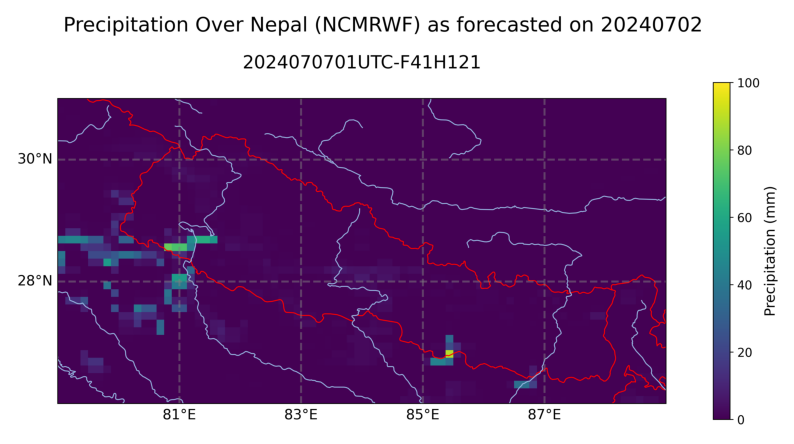

In [18]:
# Install the required libraries
!pip install rasterio pyproj pandas matplotlib imageio cartopy requests

import os
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import imageio
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import requests

# Define the bounding box for the region of interest
lat_bounds = [26, 31]  # Example latitude bounds
lon_bounds = [79, 89]  # Example longitude bounds

# Define the root directory
root_dir = "20240702"
frames_dir = os.path.join(root_dir, "FRAMES")
os.makedirs(frames_dir, exist_ok=True)

# List of public URLs for TIFF files (manually specified)
tiff_urls = [
    "https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240702/NCMRWF_Nepal_2024070203F01O2024070200H003R4KMC.tif",
    "https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240702/NCMRWF_Nepal_2024070206F02O2024070200H006R4KMC.tif",
    "https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240702/NCMRWF_Nepal_2024070209F03O2024070200H009R4KMC.tif",
    # Add all other URLs up to the last one
    "https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240702/NCMRWF_Nepal_2024070701F41O2024070200H121R12.5KMC.tif"
]

# Function to download and save TIFF files
def download_tiff_files(urls, download_dir):
    tiff_files = []
    for url in urls:
        filename = os.path.join(download_dir, os.path.basename(url))
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(filename, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            tiff_files.append(filename)
        else:
            print(f"Failed to download {url}")
    return tiff_files

# Download the TIFF files
tiff_files = download_tiff_files(tiff_urls, root_dir)
print("Downloaded TIFF files:", tiff_files)

# Function to plot precipitation data over Nepal from TIFF files
def animate_precipitation_data_tiff(tiff_files):
    # Plot each TIFF file
    for i, file_path in enumerate(tiff_files):
        with rasterio.open(file_path) as src:
            precipitation = src.read(1)
            bounds = src.bounds

            fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
            ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())
            ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle='-', linewidth=1, edgecolor='red')
            ax.add_feature(cfeature.RIVERS)

            # Define the extent explicitly using bounds
            im = ax.imshow(precipitation, cmap='viridis', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top], transform=ccrs.PlateCarree(), vmin=0, vmax=100)

            # Set the title with the file name
            filename = os.path.basename(file_path)

            # Split the filename by underscores to get parts
            parts = filename.split('_')

            # Extract the timestamp part and remove any additional characters
            timestamp = parts[2].split('F')[0]  # 'F' is the separator

            # Extract the forecast index part and remove any additional characters
            forecastIndex = parts[2].split('F')[1].split('O')[0]  # 'F' is the separator

            # Extract the forecast hours part and remove any additional characters
            forecastHrsPart = parts[2].split('H')[1]  # 'H' is the separator
            forecastHrs = forecastHrsPart.split('R')[0]  # 'H' is the separator

            # Use the extracted timestamp and forecast hours as title
            title = timestamp + 'UTC-F' + forecastIndex + 'H' + forecastHrs

            ax.set_title(title, fontsize=18, pad=30)

            # Set up gridlines
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
            gl.top_labels = False  # Hide top labels
            gl.right_labels = False  # Hide right labels
            gl.xformatter = LongitudeFormatter()
            gl.yformatter = LatitudeFormatter()
            gl.xlabel_style = {'size': 14}
            gl.ylabel_style = {'size': 14}

            # Extract longitude and latitude values for gridlines
            lon_ticks = np.arange(lon_bounds[0], lon_bounds[1] + 1, 2)
            lat_ticks = np.arange(lat_bounds[0], lat_bounds[1] + 1, 2)

            # Set gridline locations
            gl.xlocator = plt.FixedLocator(lon_ticks)
            gl.ylocator = plt.FixedLocator(lat_ticks)

            # Set a common title for all subplots
            fig.suptitle(f"Precipitation Over Nepal (NCMRWF) as forecasted on {root_dir}", fontsize=20, y=0.90)

            # Add a single colorbar for the plot and create a color bar with range 0 to 100
            norm = mcolors.Normalize(vmin=0, vmax=100)
            cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.07, fraction=0.025, norm=norm, location='right')
            cbar.set_label('Precipitation (mm)', fontsize=14)
            cbar.ax.yaxis.set_tick_params(labelsize=12)  # Adjust font size of color bar values

            # Save each frame
            frame_filename = os.path.join(frames_dir, f'frame_{i:04d}.png')
            plt.savefig(frame_filename, bbox_inches='tight', dpi=400)
            plt.close(fig)

    print("Frames saved successfully.")

    # Create an animated GIF from the frames with a delay between frames
    frame_files = sorted([os.path.join(frames_dir, f) for f in os.listdir(frames_dir) if f.endswith('.png')])
    gif_filename = os.path.join(root_dir, f'precipitation_animation_{root_dir}.gif')
    with imageio.get_writer(gif_filename, mode='I', duration=1) as writer:  # 1-second delay
        for frame_file in frame_files:
            image = imageio.v2.imread(frame_file)
            writer.append_data(image)

    print(f"Animation saved as {gif_filename}.")

    # Function to update each frame
    def update(frame):
        im.set_data(plt.imread(frame_files[frame]))
        return im,

    # Create a figure without the outer frame
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.axis('off')  # Turn off the axis

    # Display the first frame
    im = ax.imshow(plt.imread(frame_files[0]))

    # Create the animation with the specified interval
    ani = FuncAnimation(fig, update, frames=len(frame_files), interval=1000)

    # Display the animation
    return HTML(ani.to_html5_video())

# Call the function to plot precipitation data
animate_precipitation_data_tiff(tiff_files)


Generated TIFF URLs: ['https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240701/NCMRWF_Nepal_2024070103F01O2024070100H003R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240701/NCMRWF_Nepal_2024070106F02O2024070100H006R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240701/NCMRWF_Nepal_2024070109F03O2024070100H009R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240701/NCMRWF_Nepal_2024070112F04O2024070100H012R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240701/NCMRWF_Nepal_2024070115F05O2024070100H015R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240701/NCMRWF_Nepal_2024070118F06O2024070100H018R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240701/NCMRWF_Nepal_2024070121F07O2024070100H021R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240701/NCMRWF_Nepal_2024070200F08O2024070100H024R4KMC.

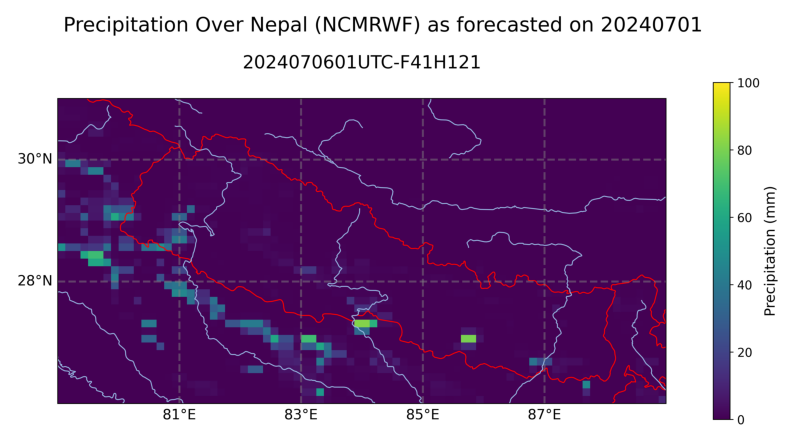

In [5]:
# Install the required libraries
!pip install rasterio pyproj pandas matplotlib imageio cartopy requests

import os
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import imageio
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import requests
from datetime import datetime, timedelta

# Define the bounding box for the region of interest
lat_bounds = [26, 31]  # Example latitude bounds
lon_bounds = [79, 89]  # Example longitude bounds

# Define the root directory
root_dir = "20240701"
frames_dir = os.path.join(root_dir, "FRAMES")
os.makedirs(frames_dir, exist_ok=True)

# Define the base URI
uri_base = "https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240701/"

# Define the forecast origin date
forecast_origin_date = datetime.strptime("20240701", "%Y%m%d")

# Function to pad numbers
def pad2(num):
    return str(num).zfill(2)

def pad3(num):
    return str(num).zfill(3)

# Generate the list of URIs
tiff_urls = []
for i in range(1, 42):
    if i <= 25:
        time_step_hours = i * 3
        file_suffix = 'R4KMC.tif'
    else:
        time_step_hours = i * 3 - 2
        file_suffix = 'R12.5KMC.tif'

    time_step_str = pad3(time_step_hours)
    forecast_hour_index = pad2(i)
    forecast_time = forecast_origin_date + timedelta(hours=time_step_hours)
    forecast_time_str = forecast_time.strftime('%Y%m%d%H')

    uri = f"{uri_base}NCMRWF_Nepal_{forecast_time_str}F{forecast_hour_index}O{root_dir}00H{time_step_str}{file_suffix}"
    tiff_urls.append(uri)

print("Generated TIFF URLs:", tiff_urls)

# Function to download and save TIFF files
def download_tiff_files(urls, download_dir):
    tiff_files = []
    for url in urls:
        filename = os.path.join(download_dir, os.path.basename(url))
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(filename, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            tiff_files.append(filename)
        else:
            print(f"Failed to download {url}")
    return tiff_files

# Download the TIFF files
tiff_files = download_tiff_files(tiff_urls, root_dir)
print("Downloaded TIFF files:", tiff_files)

# Function to plot precipitation data over Nepal from TIFF files
def animate_precipitation_data_tiff(tiff_files):
    # Plot each TIFF file
    for i, file_path in enumerate(tiff_files):
        with rasterio.open(file_path) as src:
            precipitation = src.read(1)
            bounds = src.bounds

            fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
            ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())
            ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle='-', linewidth=1, edgecolor='red')
            ax.add_feature(cfeature.RIVERS)

            # Define the extent explicitly using bounds
            im = ax.imshow(precipitation, cmap='viridis', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top], transform=ccrs.PlateCarree(), vmin=0, vmax=100)

            # Set the title with the file name
            filename = os.path.basename(file_path)

            # Split the filename by underscores to get parts
            parts = filename.split('_')

            # Extract the timestamp part and remove any additional characters
            timestamp = parts[2].split('F')[0]  # 'F' is the separator

            # Extract the forecast index part and remove any additional characters
            forecastIndex = parts[2].split('F')[1].split('O')[0]  # 'F' is the separator

            # Extract the forecast hours part and remove any additional characters
            forecastHrsPart = parts[2].split('H')[1]  # 'H' is the separator
            forecastHrs = forecastHrsPart.split('R')[0]  # 'H' is the separator

            # Use the extracted timestamp and forecast hours as title
            title = timestamp + 'UTC-F' + forecastIndex + 'H' + forecastHrs

            ax.set_title(title, fontsize=18, pad=30)

            # Set up gridlines
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
            gl.top_labels = False  # Hide top labels
            gl.right_labels = False  # Hide right labels
            gl.xformatter = LongitudeFormatter()
            gl.yformatter = LatitudeFormatter()
            gl.xlabel_style = {'size': 14}
            gl.ylabel_style = {'size': 14}

            # Extract longitude and latitude values for gridlines
            lon_ticks = np.arange(lon_bounds[0], lon_bounds[1] + 1, 2)
            lat_ticks = np.arange(lat_bounds[0], lat_bounds[1] + 1, 2)

            # Set gridline locations
            gl.xlocator = plt.FixedLocator(lon_ticks)
            gl.ylocator = plt.FixedLocator(lat_ticks)

            # Set a common title for all subplots
            fig.suptitle(f"Precipitation Over Nepal (NCMRWF) as forecasted on {root_dir}", fontsize=20, y=0.90)

            # Add a single colorbar for the plot and create a color bar with range 0 to 100
            norm = mcolors.Normalize(vmin=0, vmax=100)
            cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.07, fraction=0.025, norm=norm, location='right')
            cbar.set_label('Precipitation (mm)', fontsize=14)
            cbar.ax.yaxis.set_tick_params(labelsize=12)  # Adjust font size of color bar values

            # Save each frame
            frame_filename = os.path.join(frames_dir, f'frame_{i:04d}.png')
            plt.savefig(frame_filename, bbox_inches='tight', dpi=400)
            plt.close(fig)

    print("Frames saved successfully.")

    # Create an animated GIF from the frames with a delay between frames
    frame_files = sorted([os.path.join(frames_dir, f) for f in os.listdir(frames_dir) if f.endswith('.png')])
    gif_filename = os.path.join(root_dir, f'precipitation_animation_{root_dir}.gif')
    with imageio.get_writer(gif_filename, mode='I', duration=1) as writer:  # 1-second delay
        for frame_file in frame_files:
            image = imageio.v2.imread(frame_file)
            writer.append_data(image)

    print(f"Animation saved as {gif_filename}.")

    # Function to update each frame
    def update(frame):
        im.set_data(plt.imread(frame_files[frame]))
        return im,

    # Create a figure without the outer frame
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.axis('off')  # Turn off the axis

    # Display the first frame
    im = ax.imshow(plt.imread(frame_files[0]))

    # Create the animation with the specified interval
    ani = FuncAnimation(fig, update, frames=len(frame_files), interval=1000)

    # Display the animation
    return HTML(ani.to_html5_video())

# Call the function to plot precipitation data
animate_precipitation_data_tiff(tiff_files)
